In [1]:
%matplotlib inline


Agglomerative clustering with different metrics
===============================================

Demonstrates the effect of different metrics on the hierarchical clustering.

The example is engineered to show the effect of the choice of different
metrics. It is applied to waveforms, which can be seen as
high-dimensional vector. Indeed, the difference between metrics is
usually more pronounced in high dimension (in particular for euclidean
and cityblock).

We generate data from three groups of waveforms. Two of the waveforms
(waveform 1 and waveform 2) are proportional one to the other. The cosine
distance is invariant to a scaling of the data, as a result, it cannot
distinguish these two waveforms. Thus even with no noise, clustering
using this distance will not separate out waveform 1 and 2.

We add observation noise to these waveforms. We generate very sparse
noise: only 6% of the time points contain noise. As a result, the
l1 norm of this noise (ie "cityblock" distance) is much smaller than it's
l2 norm ("euclidean" distance). This can be seen on the inter-class
distance matrices: the values on the diagonal, that characterize the
spread of the class, are much bigger for the Euclidean distance than for
the cityblock distance.

When we apply clustering to the data, we find that the clustering
reflects what was in the distance matrices. Indeed, for the Euclidean
distance, the classes are ill-separated because of the noise, and thus
the clustering does not separate the waveforms. For the cityblock
distance, the separation is good and the waveform classes are recovered.
Finally, the cosine distance does not separate at all waveform 1 and 2,
thus the clustering puts them in the same cluster.


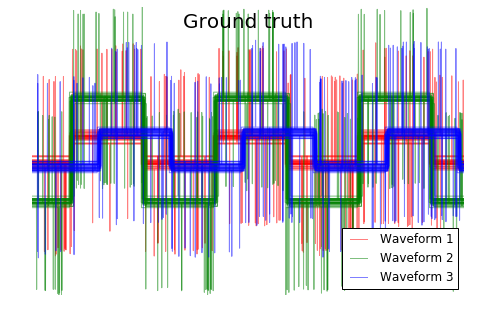

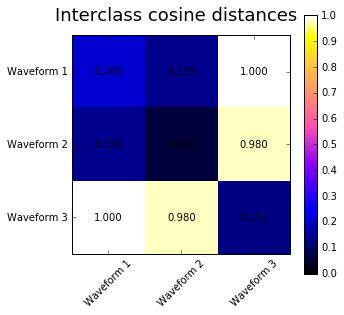

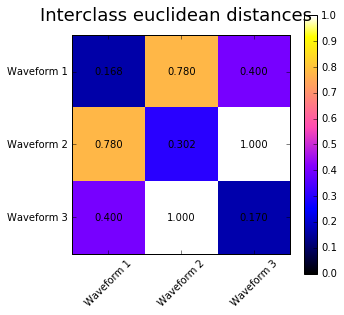

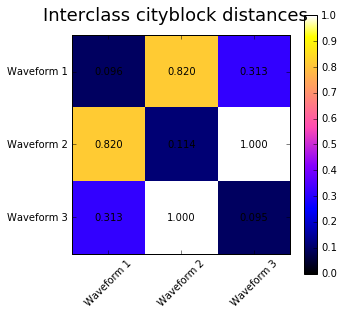

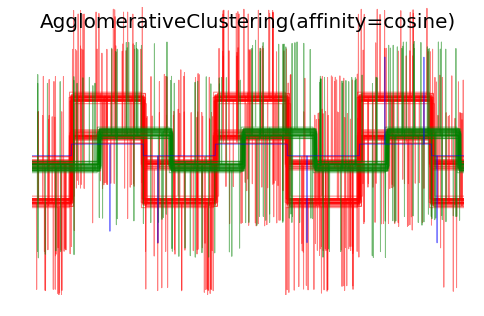

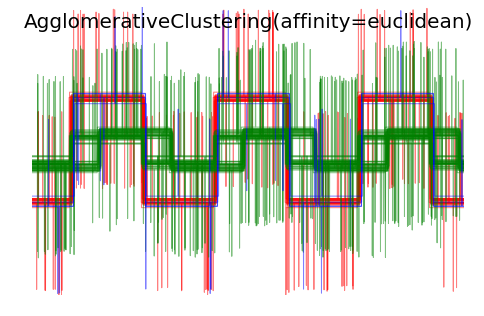

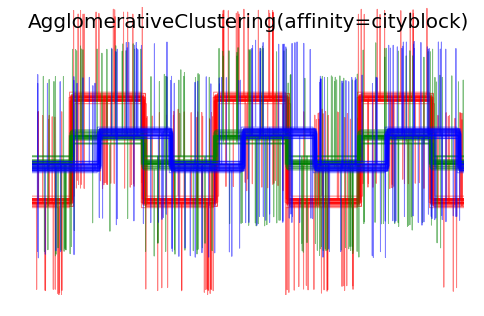

In [2]:
# Author: Gael Varoquaux
# License: BSD 3-Clause or CC-0

import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import pairwise_distances

np.random.seed(0)

# Generate waveform data
n_features = 2000
t = np.pi * np.linspace(0, 1, n_features)


def sqr(x):
    return np.sign(np.cos(x))

X = list()
y = list()
for i, (phi, a) in enumerate([(.5, .15), (.5, .6), (.3, .2)]):
    for _ in range(30):
        phase_noise = .01 * np.random.normal()
        amplitude_noise = .04 * np.random.normal()
        additional_noise = 1 - 2 * np.random.rand(n_features)
        # Make the noise sparse
        additional_noise[np.abs(additional_noise) < .997] = 0

        X.append(12 * ((a + amplitude_noise)
                 * (sqr(6 * (t + phi + phase_noise)))
                 + additional_noise))
        y.append(i)

X = np.array(X)
y = np.array(y)

n_clusters = 3

labels = ('Waveform 1', 'Waveform 2', 'Waveform 3')

# Plot the ground-truth labelling
plt.figure()
plt.axes([0, 0, 1, 1])
for l, c, n in zip(range(n_clusters), 'rgb',
                   labels):
    lines = plt.plot(X[y == l].T, c=c, alpha=.5)
    lines[0].set_label(n)

plt.legend(loc='best')

plt.axis('tight')
plt.axis('off')
plt.suptitle("Ground truth", size=20)


# Plot the distances
for index, metric in enumerate(["cosine", "euclidean", "cityblock"]):
    avg_dist = np.zeros((n_clusters, n_clusters))
    plt.figure(figsize=(5, 4.5))
    for i in range(n_clusters):
        for j in range(n_clusters):
            avg_dist[i, j] = pairwise_distances(X[y == i], X[y == j],
                                                metric=metric).mean()
    avg_dist /= avg_dist.max()
    for i in range(n_clusters):
        for j in range(n_clusters):
            plt.text(i, j, '%5.3f' % avg_dist[i, j],
                     verticalalignment='center',
                     horizontalalignment='center')

    plt.imshow(avg_dist, interpolation='nearest', cmap=plt.cm.gnuplot2,
               vmin=0)
    plt.xticks(range(n_clusters), labels, rotation=45)
    plt.yticks(range(n_clusters), labels)
    plt.colorbar()
    plt.suptitle("Interclass %s distances" % metric, size=18)
    plt.tight_layout()


# Plot clustering results
for index, metric in enumerate(["cosine", "euclidean", "cityblock"]):
    model = AgglomerativeClustering(n_clusters=n_clusters,
                                    linkage="average", affinity=metric)
    model.fit(X)
    plt.figure()
    plt.axes([0, 0, 1, 1])
    for l, c in zip(np.arange(model.n_clusters), 'rgbk'):
        plt.plot(X[model.labels_ == l].T, c=c, alpha=.5)
    plt.axis('tight')
    plt.axis('off')
    plt.suptitle("AgglomerativeClustering(affinity=%s)" % metric, size=20)


plt.show()